# COVIDcast Data Smoothing
In this document, we compare different methods of smoothing [COVIDcast signals](https://github.com/cmu-delphi/delphi-epidata/blob/e7cd1012d2046980571a3ded6db6803f64e4506b/docs/api/covidcast_signals.md). See the README.md file for the problem statement and the mathematical background.

To rerun this notebook, `covidcast` and `delphi_utils` from [this branch](https://github.com/cmu-delphi/covidcast-indicators/tree/dev-smoothing) should be installed in your python environment. The other dependencies are below.

In [1]:
import os
from datetime import date, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import covidcast
from delphi_utils import Smoother

## Smoother Behaviors on Google Health Trends, MSA Region in Chattanooga
Here we explore the questions brought up in [this issue](https://github.com/cmu-delphi/covidcast-indicators/issues/67). We reproduce the specific plots mentioned in this [comment](https://github.com/cmu-delphi/covidcast-indicators/issues/67#issuecomment-643515698) by @brookslogan and demonstrate how different smoothers behave on the data. Click the link in the comment prior and view the time graph (bottom right) to see the sawtoothed behavior.

Let's reproduce this behavior by looking at the raw data and smoothing it.

In [2]:
filename = "ght-raw_search_msa_16860.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal("ght", "raw_search", 
                                start_day=None, end_day=None,
                                geo_type="msa", geo_values="16860")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)
    data_raw.time_value = pd.to_datetime(data_raw.time_value)

The first plot below shows how sawtoothed spiking behavior arises. The raw data is sparse with periodic large spikes. The existing local linear regression smoother decays in the zero windows, making it hard to see an overall trend.

What would we rather see instead? The answer to this will depend on our use cases in visualization and in forecasting, of course. But as Addison wrote in the Github thread, a reasonable thing to aim for is to produce curves that are "as smooth as possible without sacrificing the ability to tell that there was a jump today".

While the existing smoother fits local linear trends to the data and picks up noise from the spikes, `savgol poly_deg=0` is more resistant to the noise.

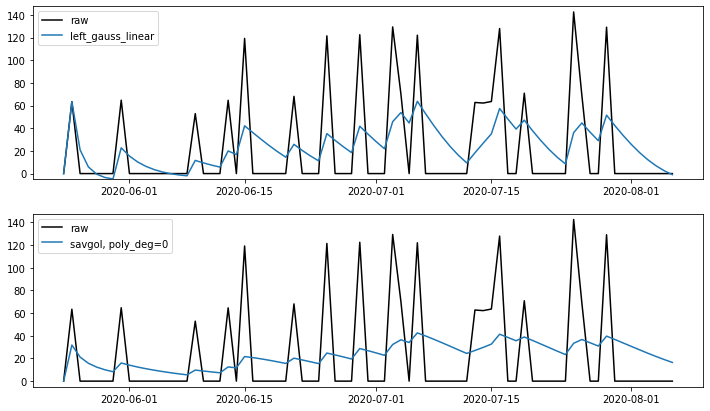

In [3]:
data_raw = data_raw.loc[data_raw.time_value >= datetime(2020, 5, 24)]

plt.figure(figsize=(12, 7))
plt.title("Chattanooga-TN-GA")
ax = plt.subplot(2, 1, 1)
plt.plot(data_raw.time_value.to_numpy(), data_raw.value.to_numpy(), label="raw", color='black')
plt.plot(data_raw.time_value.to_numpy(), Smoother(smoother_name="left_gauss_linear").smooth(data_raw.value.to_numpy()), label="left_gauss_linear")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

ax = plt.subplot(2, 1, 2)
plt.plot(data_raw.time_value.to_numpy(), data_raw.value.to_numpy(), label="raw", color='black')
plt.plot(data_raw.time_value.to_numpy(), Smoother(smoother_name="savgol", poly_fit_degree=0).smooth(data_raw.value.to_numpy()), label="savgol, poly_deg=0")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

## Smoother Behaviors on Google Health Trends, Sacramento and Pittsburgh Hospital Referral Regions
Let's see the new smoother on a different region.

In [4]:
filename = "ght_raw_hrr_pittsburgh.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal("ght", "raw_search", 
                                start_day=None, end_day=None,
                                geo_type="hrr", geo_values="357")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

In the four plots below, we show the performance of each smoother on 2 different time windows: 14 and 7 days. We can see a tradeoff: a shorter time-window reduces the smoothing lag, but increases the noise. I think 14 days looks fine, but the choice will depend on use cases.

Again, overall `savgol` is more resistant to the spiking noise here.

(What is the new smoother? Well, simplifying a little, `left_gauss_linear` smooths by fitting a line through the most recent 3 weeks of data, exponentially favoring the most recent data, while `savgol` uses the same exponential weights, but fits a constant line.)

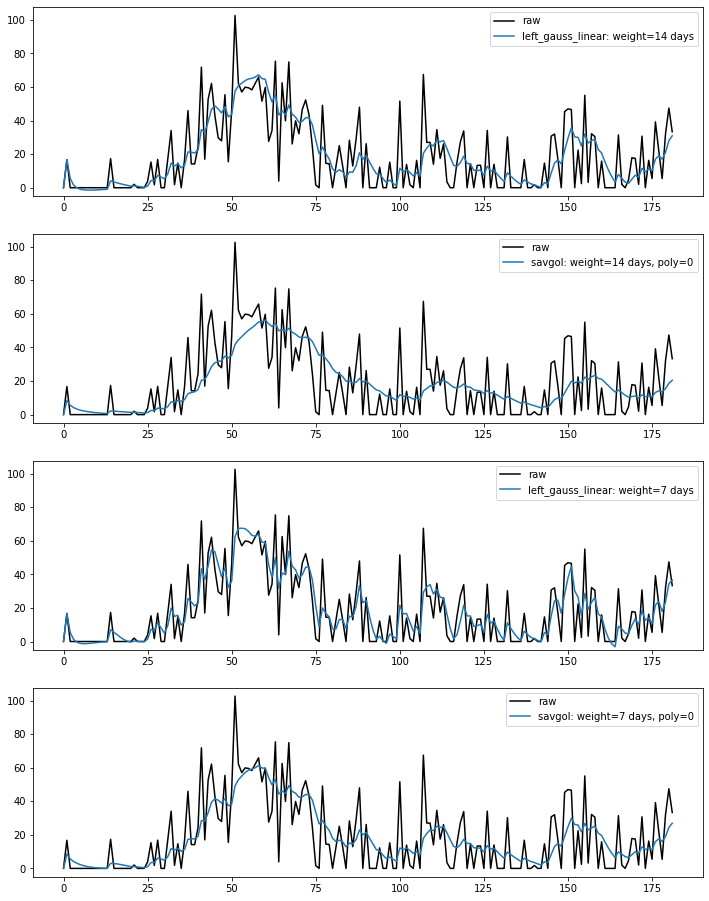

In [5]:
plt.figure(figsize=(12, 16))
plt.title("GHT HRR Pittsburgh")
ax = plt.subplot(4, 1, 1)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(smoother_name='left_gauss_linear', gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=14 days")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

ax = plt.subplot(4, 1, 2)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=0")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

ax = plt.subplot(4, 1, 3)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(smoother_name='left_gauss_linear', gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=7 days")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

ax = plt.subplot(4, 1, 4)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=7 days, poly=0")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

Looking at another hospital region, Sacramento, the same pattern holds.

In [6]:
filename = "ght_raw_hrr_sacramento.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal("ght", "raw_search", 
                                start_day=None, end_day=None,
                                geo_type="hrr", geo_values="77")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

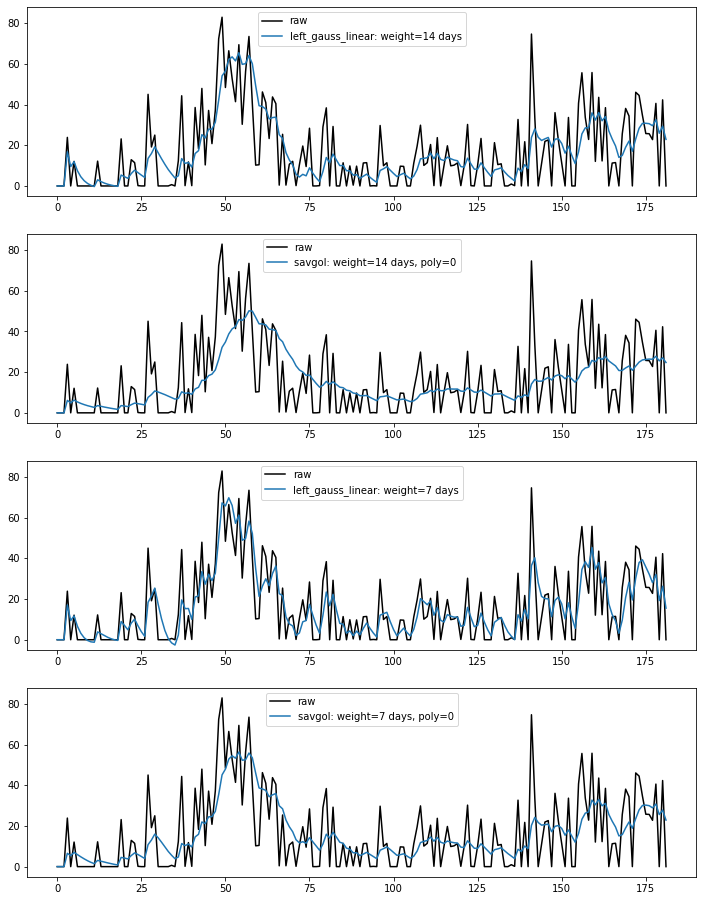

In [7]:
plt.figure(figsize=(12, 16))
plt.title("GHT HRR Sacramento")
ax = plt.subplot(4, 1, 1)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(smoother_name='left_gauss_linear', gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=14 days")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

ax = plt.subplot(4, 1, 2)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=0")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

ax = plt.subplot(4, 1, 3)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(smoother_name='left_gauss_linear', gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=7 days")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

ax = plt.subplot(4, 1, 4)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=7 days, poly=0")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

## Smoother Behavior On JHU-CSSE in Allegheny and Yolo Counties
The same analysis on a different indicator, `jhu-csse` at the county level. Same patterns.

In [8]:
filename = "jhu_confirmed_incidence_county_yolo.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal(data_source="jhu-csse", 
                                signal="confirmed_incidence_num", 
                                start_day=None, 
                                end_day=None, 
                                geo_type="county", 
                                geo_values="06113")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

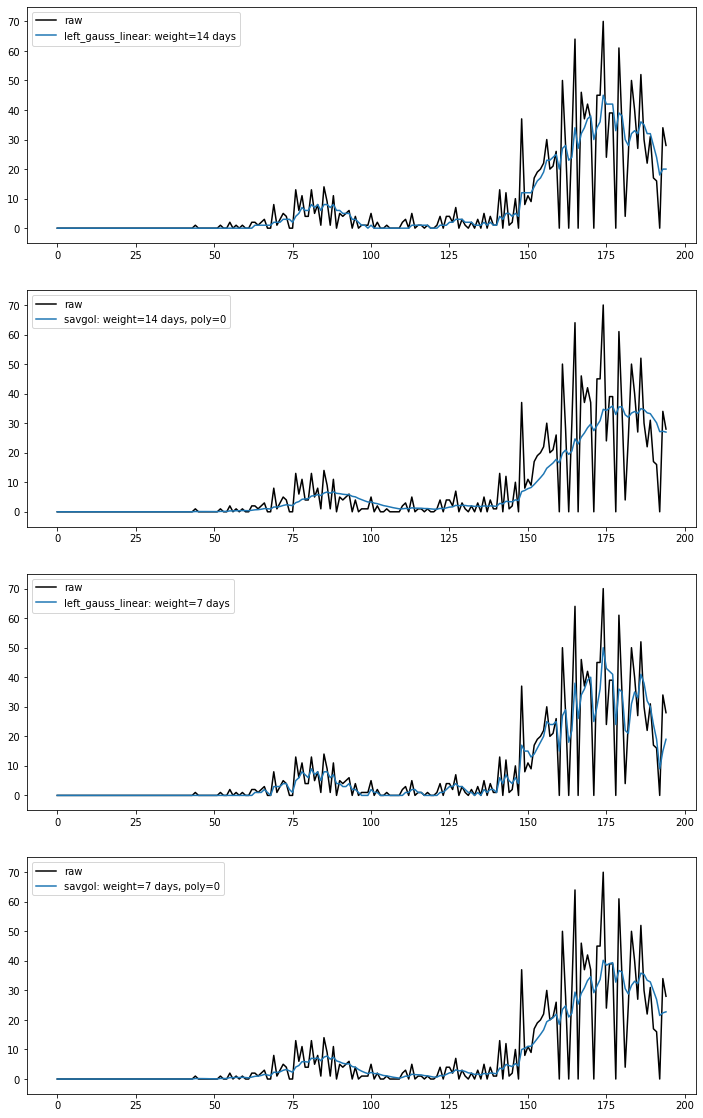

In [9]:
plt.figure(figsize=(12, 20))
plt.title("JHU County Yolo")
ax = plt.subplot(4, 1, 1)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(smoother_name='left_gauss_linear', gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=14 days")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

ax = plt.subplot(4, 1, 2)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=0")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

ax = plt.subplot(4, 1, 3)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(smoother_name='left_gauss_linear', gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=7 days")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

ax = plt.subplot(4, 1, 4)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=7 days, poly=0")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

Allegheny county supports the result.

In [10]:
filename = "jhu_confirmed_incidence_county_allegheny.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal(data_source="jhu-csse", 
                                signal="confirmed_incidence_num", 
                                start_day=None, 
                                end_day=None, 
                                geo_type="county", 
                                geo_values="42003")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

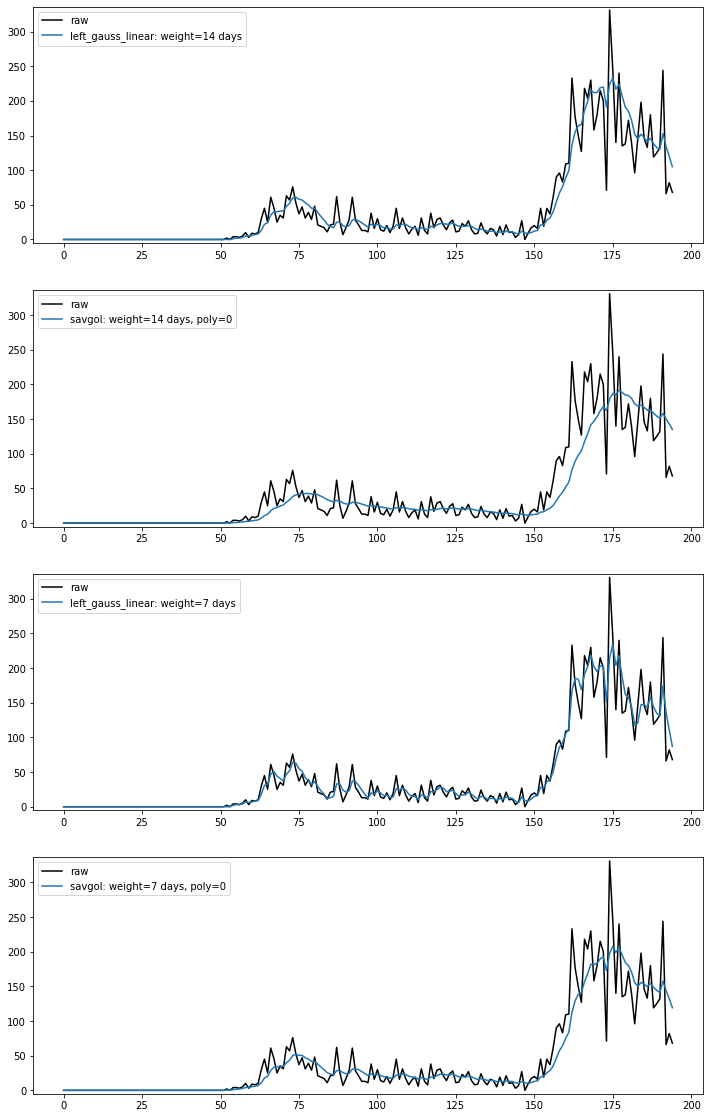

In [11]:
plt.figure(figsize=(12, 20))
plt.title("JHU County Allegheny")
ax = plt.subplot(4, 1, 1)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(smoother_name='left_gauss_linear', gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=14 days")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

ax = plt.subplot(4, 1, 2)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=0")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

ax = plt.subplot(4, 1, 3)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(smoother_name='left_gauss_linear', gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=7 days")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

ax = plt.subplot(4, 1, 4)
plt.plot(np.array(data_raw.value), label="raw", color='black')
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=7 days, poly=0")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

## Smoother Behavior on Google Health Trends at the California Scale

In [12]:
filename = "ght_raw.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal("ght", "raw_search", 
                                start_day=None, end_day=None,
                                geo_type="state", geo_values="ca")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

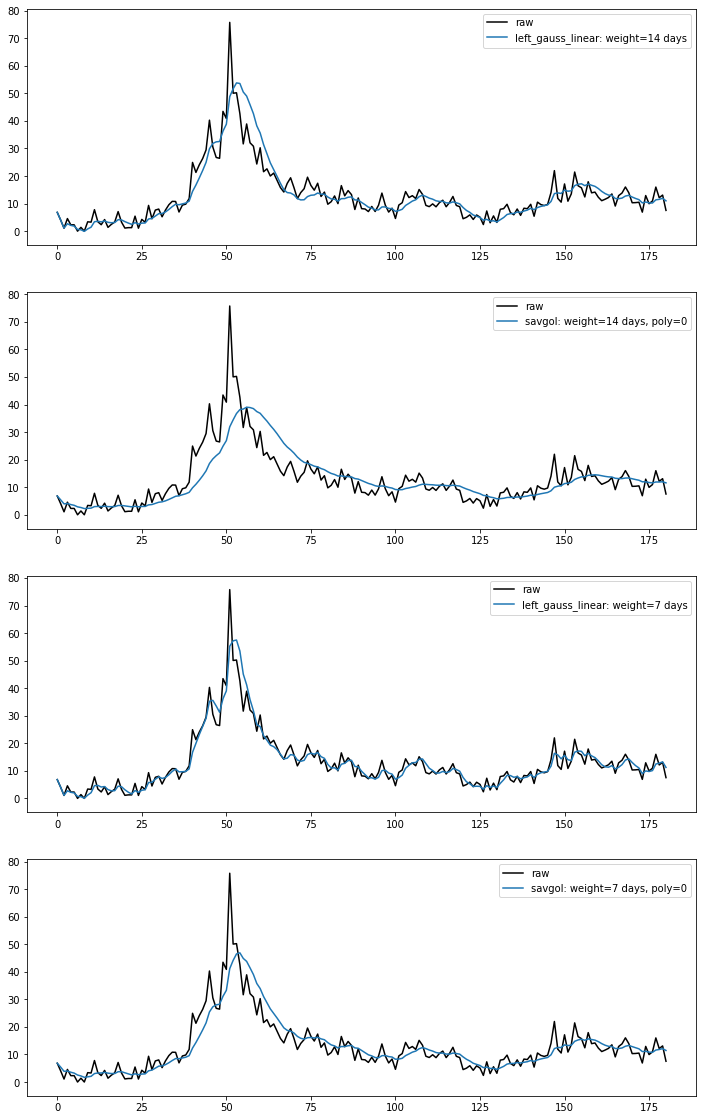

In [13]:
plt.figure(figsize=(12, 20))
plt.title("GHT Raw California")
ax = plt.subplot(4, 1, 1)
plt.plot(np.array(data_raw.value), label="raw", color="black")
smoother = Smoother(smoother_name='left_gauss_linear', gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=14 days")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

ax = plt.subplot(4, 1, 2)
plt.plot(np.array(data_raw.value), label="raw", color="black")
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=0")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

ax = plt.subplot(4, 1, 3)
plt.plot(np.array(data_raw.value), label="raw", color="black")
smoother = Smoother(smoother_name='left_gauss_linear', gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=7 days")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

ax = plt.subplot(4, 1, 4)
plt.plot(np.array(data_raw.value), label="raw", color="black")
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=36)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=7 days, poly=0")
ax.set_ylim([data_raw.value.min()-5, data_raw.value.max()+5])
plt.legend()

Note that `savgol` with polynomial degree 1 is essentially identical to `left_gauss_linear` (modulo some window length differences). The `savgol` implementation is faster, so in the future should replace `left_gauss_linear`.

In [14]:
lgl_smoother = Smoother(smoother_name='left_gauss_linear')
sg_smoother = Smoother(poly_fit_degree=1)
np.allclose(sg_smoother.smooth(np.array(data_raw.value)), lgl_smoother.smooth(np.array(data_raw.value)), atol=2)

True

## Imputing Through Filtering versus Zero-filling
A lot of data arrives to us already zero-filled. The unfortunate thing is that a nan is a more accurate representation of the state of knowledge -- a lack of reporting on a given day is not a true zero. 

The first plot shows a basic example of the visual pathologies that occur with zero-filling. The second plot shows how fitting on the past and ignoring the zero value better reproduces the true trend.

I don't know yet how pervasive nans are throughout our data. It does seem like zero-filled data is heavily prevalent in the raw data. Maybe it would make sense to treat zeros in those cases in the same way that we handle nans.

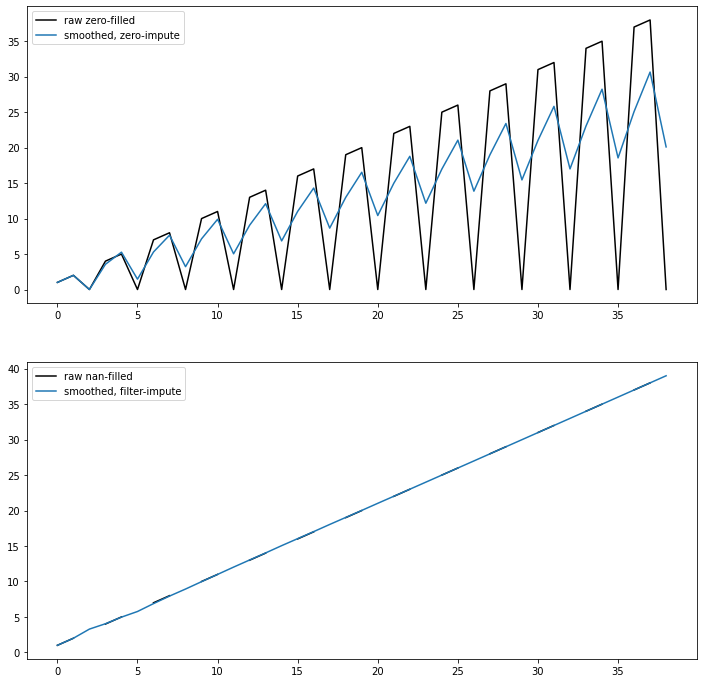

In [15]:
signal = np.array([i if i % 3 else np.nan for i in range(1, 40)])
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(np.nan_to_num(signal), label="raw zero-filled", color="black")
plt.plot(Smoother(impute_method="zeros").smooth(signal), label="smoothed, zero-impute")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(signal, label="raw nan-filled", color="black")
plt.plot(Smoother().smooth(signal), label="smoothed, filter-impute")
plt.legend()

## Conclusion
As we have seen, `savgol` with polynomial degree 0 provides reasonable smoothing in the sparse regime. This comes at the cost of some lag, so the weighing window must be reduced. This lag may be too large for the raw data, even with a 7 day window to reduce it, so it may be best to continue to use the 1 degree polynomial fit there, depending on our needs.

## Other Signals
Many of the other signals had obstacles to a clear comparison.

- The `doctor-visits` and `hospital-admissions` are already smoothed by the provider. The raw data does not appear to be available.
- The `fb-survey` and `google-survey` signal require access to the survey data, which I don't have yet.